# Models Training and Evaluation

## Data preprocessing

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import csv
import re
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import itertools

[nltk_data] Downloading package punkt to /home/riccardo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Importing the dataset
file_path = os.path.join("..", "input", "dataset_eng_cleaned.csv")

df = pd.read_csv(file_path, index_col = 0, names=["text", "label"])

# Defining a function to perform data cleaning
def clean_text(text):
    # 1) Removing punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # 2) Getting rid of numbers
    text = re.sub(r'\d+', '', text)
    # 3) Removing words which have 2 or less letters
    text = ' '.join([word for word in text.split() if len(word) > 2])
    # 4) Making text lowercase
    return text.lower()

# Applying the function to the text column
df["text"] = df["text"].apply(clean_text)

In [3]:
df.head()

,text,label
UsNB_SOM2_DOC1_0012,technological refresh the som which involveso ...,1
UsNB_SOM2_DOC1_0013,creation second server room the san donato sit...,1
UsNB_SOM2_DOC1_0014,creation second operations room disaster recov...,1
UsNB_SOM2_DOC1_0015,porting the alstom software onto the new alsto...,1
UsNB_SOM2_DOC1_0016,moving replacing software telex rich client,1


In [4]:
requirement_words = [
    'must', 'shall', 'should', 'need', 'require', 'necessary',
    'obligated', 'mandatory', 'compulsory', 'demanded', 'essential',
    'prerequisite', 'prerequisites', 'precondition', 'condition', 'necessary', 'needful',
    'requisite', 'requisites', 'needed', 'expected', 'necessary', 'demand', 'expectation',
    'require', 'specification', 'guideline', 'instruction', 'necessity',
    'stipulation', 'condition', 'request', 'necessitate', 'requirement',
    'requirements'
]

In [5]:
import numpy as np

def assign_custom_label(X_test, y_pred, requirement_words):
    for i in range(X_test.shape[0]): 
        if not isinstance(X_test[i], np.ndarray):
            words_in_sentence = set(np.flatnonzero(X_test[i].toarray()))  
        else:
            words_in_sentence = set(np.flatnonzero(X_test[i]))
        for word in requirement_words:
            if word in words_in_sentence:
                y_pred[i] = 1
                break
    return y_pred

## Bag of Words

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

X = df["text"]
y = df["label"]
vectorizer = CountVectorizer(stop_words='english')
X_cv = vectorizer.fit_transform(X)

# Creating custom binary features for positive indicator words
custom_features = np.zeros((X_cv.shape[0], len(requirement_words)))

for i, text in enumerate(X_cv):
    for j, word in enumerate(requirement_words):
        if word in df["text"]:
            custom_features[i, j] = 1

# Combining the bag-of-words features with the custom features
X_combined = np.hstack((X_cv.toarray(), custom_features))

# splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, \
                                   test_size=0.2, random_state=42)

In [7]:
# Computing the class weights
total_samples = len(y_train)
class_0_samples = (y_train == 0).sum()
class_1_samples = (y_train == 1).sum()

weight_for_class_0 = total_samples / (2 * class_0_samples)
weight_for_class_1 = total_samples / (2 * class_1_samples)

class_weights = {0: weight_for_class_0, 1: weight_for_class_1}

### Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model_lr = LogisticRegression(class_weight = class_weights, solver='sag',\
                              max_iter=1000)

# training the model
model_lr.fit(X_train, y_train)

# making predictions on the test data
y_pred_lr = assign_custom_label(X_test, model_lr.predict(X_test), requirement_words)

# model evaluation
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.57      0.77      0.66       735
           1       0.89      0.75      0.81      1706

    accuracy                           0.76      2441
   macro avg       0.73      0.76      0.74      2441
weighted avg       0.79      0.76      0.77      2441



/home/riccardo/miniconda3/envs/alstom/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


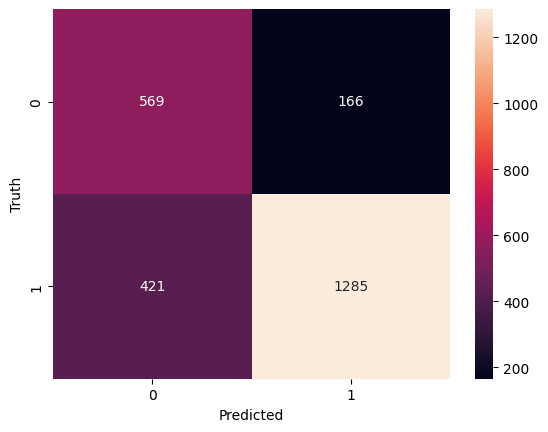

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# computing the confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

# creating a heatmap
plt.figure()
label_names = list(model_lr.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels = label_names, yticklabels = label_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [11]:
# Geting the coefficients from the trained linear model
coefficients = model_lr.coef_[0]

# Geting the list of words (features) from the CountVectorizer
words = vectorizer.get_feature_names_out()

# Creating a list of (word, coefficient) pairs and sort them based on the absolute coefficient values
word_coefficient_pairs = list(zip(words, coefficients))
word_coefficient_pairs.sort(key=lambda x: abs(x[1]), reverse=True)

# Printing the top 30 most important words
print("Top 30 Most Important Words:")
for word, coefficient in word_coefficient_pairs[:30]:
    print(f"{word}: {coefficient}")

Top 30 Most Important Words:
vii: 2.276233134170635
ertmsetcs: -2.0019300430614653
means: -1.8821216586442526
defines: -1.8738509698256947
lan: -1.7950755467655213
identify: 1.683165082409803
sqm: 1.64743535710929
develop: 1.6043401076186985
enodeb: 1.5900294304696334
iii: 1.5808481997574457
utilities: -1.5377737609066682
send: 1.532281495624372
limitation: -1.5315978406880812
deleted: -1.520757173076559
cip: -1.5164257442760618
link: 1.509533773568404
note: -1.505305365103603
all_: 1.5041528134672233
visual: 1.5036390645979858
general: -1.4768115024586514
janus: 1.4691897902531532
equipments: 1.433274713892894
gpp: 1.4317085788072776
ccs: -1.430056374431311
rfi: -1.4258980801823014
normal: 1.4060460549191236
mmis: -1.4023434276026754
emi: 1.3933190871585044
pipes: -1.3895725358368363
structure: 1.3860233017489771


### SVM

In [11]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

svm_model = LinearSVC(class_weight = class_weights)

svm_model.fit(X_train, y_train)

# Making predictions on the test data
y_pred_svm = assign_custom_label(X_test, svm_model.predict(X_test), requirement_words)

# Model evaluation
print("Support Vector Machine (SVM) Results:")
print(classification_report(y_test, y_pred_svm))

Support Vector Machine (SVM) Results:
              precision    recall  f1-score   support

           0       0.59      0.77      0.67       735
           1       0.89      0.77      0.82      1706

    accuracy                           0.77      2441
   macro avg       0.74      0.77      0.75      2441
weighted avg       0.80      0.77      0.78      2441



/home/riccardo/miniconda3/envs/alstom/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


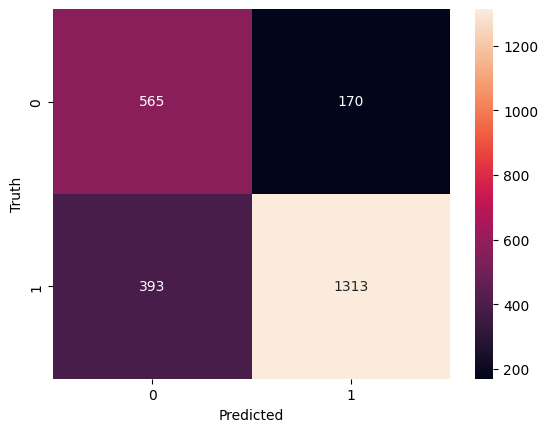

In [13]:
# computing the confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# creating a heatmap
plt.figure()
label_names = list(svm_model.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels = label_names, yticklabels = label_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [14]:
# Geting the coefficients from the trained linear model
coefficients = svm_model.coef_[0]

# Geting the list of words (features) from the CountVectorizer
words = vectorizer.get_feature_names_out()

# Creating a list of (word, coefficient) pairs and sort them based on the absolute coefficient values
word_coefficient_pairs = list(zip(words, coefficients))
word_coefficient_pairs.sort(key=lambda x: abs(x[1]), reverse=True)

# Printing the top 30 most important words
print("Top 30 Most Important Words:")
for word, coefficient in word_coefficient_pairs[:30]:
    print(f"{word}: {coefficient}")

Top 30 Most Important Words:
fuel: -2.3702147894340633
implementing: -1.7321465620360077
congestion: 1.727478106228086
identify: 1.6888639026831351
occlocal: -1.6321834564625313
formal: 1.608733017636295
achievement: 1.5655917966823183
vii: 1.5432445705675737
identifies: 1.5144070584142955
develop: 1.514350818235693
layout: 1.4989570349237085
stipulates: -1.4964495294897548
lan: -1.478705919584321
traceability: 1.4664394532624816
satisfying: -1.4600885132004342
approx: -1.4530977276289327
sqm: 1.450328719492369
send: 1.4422802069214387
describes: -1.435507984763455
equipments: 1.4312905115601917
imposing: -1.4299296054560915
gpp: 1.4226151491335866
appendixn: -1.4145282904666612
possession: -1.414324771516557
ues: 1.4121630239924525
days: 1.3966216901538622
seek: -1.396605116808529
bushing: -1.3948385826299685
potentially: -1.3879491101169723
earned: -1.3806051231647563


### Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Creating and train the Random Forest classifier
rf_model = RandomForestClassifier(class_weight = class_weights, \
                                  n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Making predictions on the test data
y_pred_rf = assign_custom_label(X_test, rf_model.predict(X_test), requirement_words)

# Model evaluation
print("Random Forest Classifier Results:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier Results:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67       735
           1       0.85      0.88      0.87      1706

    accuracy                           0.81      2441
   macro avg       0.77      0.76      0.77      2441
weighted avg       0.80      0.81      0.81      2441



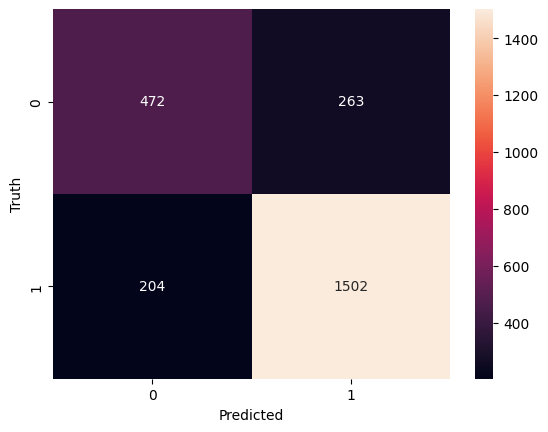

In [22]:
# computing the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# creating a heatmap
plt.figure()
label_names = list(rf_model.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels = label_names, yticklabels = label_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [23]:
# Geting the feature importances from the trained Random Forest model
feature_importances = rf_model.feature_importances_

# Geting the list of words (features) from the CountVectorizer
words = vectorizer.get_feature_names_out()

# Creating a list of (word, importance) pairs and sort them based on the importance values
word_importance_pairs = list(zip(words, feature_importances))
word_importance_pairs.sort(key=lambda x: x[1], reverse=True)

# Printing the top 30 most important words
print("Top 30 Most Important Words:")
for word, importance in word_importance_pairs[:30]:
    print(f"{word}: {importance}")

Top 30 Most Important Words:
shall: 0.06149546858303663
contractor: 0.007550938153936839
train: 0.005668401068153572
provide: 0.005638738731229927
general: 0.0050296032955233876
equipment: 0.0049878321403601985
including: 0.004935224497293421
test: 0.00485455047990204
ertmsetcs: 0.004850720892875114
following: 0.004800744517753834
support: 0.00454237681994672
design: 0.004467841171519226
required: 0.004050558582057147
point: 0.003663930384421362
management: 0.0034698715470567864
used: 0.0034349503518922913
signal: 0.0033388267969791043
requirements: 0.0032292219717465196
tests: 0.0031732039017095285
iii: 0.003050660572739488
time: 0.0028636482756833957
engineer: 0.0028094851736145533
control: 0.0028023449477045403
number: 0.0027149085343015538
include: 0.002703522306802192
plan: 0.0026637341693639166
cables: 0.002634529274950491
all_: 0.002631249081655926
eng: 0.0025408625646147066
employers: 0.00250145950973175


### Multinomial Naive Bayes

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Calculating sample weights based on class distribution
sample_weights = np.where(y_train == 0, weight_for_class_0, weight_for_class_1)

# Creating and training the Naive Bayes classifier with sample weights
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train, sample_weight=sample_weights)

# Making predictions on the test data
y_pred_nb = assign_custom_label(X_test, nb_model.predict(X_test), requirement_words)

# Model evaluation
print("Multinomial Naive Bayes Results:")
print(classification_report(y_test, y_pred_nb))

Multinomial Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.61      0.58      0.59       735
           1       0.82      0.84      0.83      1706

    accuracy                           0.76      2441
   macro avg       0.72      0.71      0.71      2441
weighted avg       0.76      0.76      0.76      2441



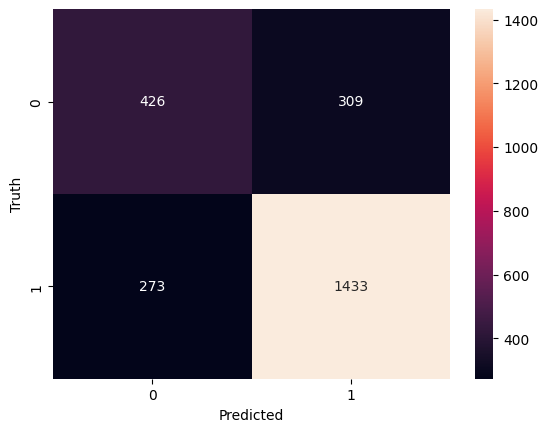

In [28]:
# computing the confusion matrix
cm = confusion_matrix(y_test, y_pred_nb)

# creating a heatmap
plt.figure()
label_names = list(nb_model.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels = label_names, yticklabels = label_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Metamodel: voting classifier

In [42]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('logistic_regression', log_reg),
        ('support_vector_machines', svm_model),
        ('random_forest', rf_model),
        ('multinomial_naive_bayes', nb_model),
    ],
    voting='hard' 
)

voting_clf.fit(X_train, y_train)

/home/riccardo/miniconda3/envs/alstom/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/riccardo/miniconda3/envs/alstom/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


VotingClassifier(estimators=[('logistic_regression',
                              LogisticRegression(class_weight={0: 1.6706023271731691,
                                                               1: 0.713565268235638})),
                             ('support_vector_machines',
                              LinearSVC(class_weight={0: 1.6706023271731691,
                                                      1: 0.713565268235638})),
                             ('random_forest',
                              RandomForestClassifier(class_weight={0: 1.6706023271731691,
                                                                   1: 0.713565268235638},
                                                     random_state=42)),
                             ('multinomial_naive_bayes', MultinomialNB())])

In [43]:
# making predictions on the test data
y_pred_voting = assign_custom_label(X_test, voting_clf.predict(X_test), requirement_words)

# model evaluation
print(classification_report(y_test, y_pred_voting))

              precision    recall  f1-score   support

           0       0.60      0.78      0.68       735
           1       0.89      0.78      0.83      1706

    accuracy                           0.78      2441
   macro avg       0.75      0.78      0.75      2441
weighted avg       0.80      0.78      0.78      2441



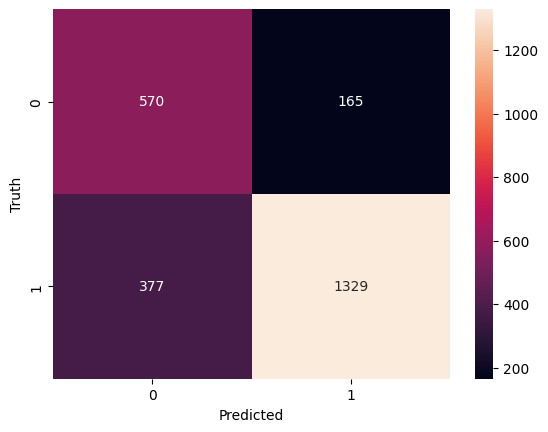

In [44]:
# computing the confusion matrix
cm = confusion_matrix(y_test, y_pred_voting)

# creating a heatmap
plt.figure()
label_names = list(voting_clf.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels = label_names, yticklabels = label_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Saving the Metamodel

In [48]:
from joblib import dump, load
dump(voting_clf, 'metamodel.pkl')
# use metamodel = joblib.load('metamodel.pkl') to reuse the trained model

['metamodel.pkl']